# Preços de carro no Brasil

Exploração das variações de preço de carro no Brasil e possíveis fatores relacionados

In [1]:
# importando bibliotecas

import numpy as np           
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# formatações e opções
%matplotlib inline
pd.options.display.float_format = '{:.4f}'.format

## Preparando os dados

Importando e tratando dados utilizados para a investigação

### Dados da tabela FIPE - preços de 2021 a 2023

In [2]:
# carregando o dataset da FIPE
df = pd.read_csv ('data/fipe_cars.csv')
df.head()

,year_of_reference,month_of_reference,fipe_code,authentication,brand,model,fuel,gear,engine_size,year_model,avg_price_brl
0,2021,January,038001-6,tlp4qry07m,Acura,NSX 3.0,Gasoline,manual,3.0000,1995,40374.0000
1,2021,January,038001-6,s1wksdv9by,Acura,NSX 3.0,Gasoline,manual,3.0000,1994,38939.0000
2,2021,January,038001-6,skrbcfnkch,Acura,NSX 3.0,Gasoline,manual,3.0000,1993,37648.0000
3,2021,January,038001-6,rxzh76d5db,Acura,NSX 3.0,Gasoline,manual,3.0000,1992,35962.0000
4,2021,January,038001-6,qrm322tpd8,Acura,NSX 3.0,Gasoline,manual,3.0000,1991,32863.0000


In [3]:
# checando consistência dos dados

print(f'Linhas: {df.shape[0]}')
print(f'Colunas (features): {df.shape[1]}')
print(f'Linhas duplicadas: {df.duplicated().sum()}')
print(f'Dados faltantes: {sum(df.isna().sum())}')

Linhas: 599007
Colunas (features): 11


Linhas duplicadas: 3
Dados faltantes: 0


In [4]:
# retirando valores duplicados

df.drop_duplicates(keep='first',inplace=True)
print(f'Linhas: {df.shape[0]}')
print(f'Linhas duplicadas: {df.duplicated().sum()}')

Linhas: 599004


Linhas duplicadas: 0


In [5]:
# adicionando coluna reference_date juntando year_of_reference e month_of_reference
df['reference_date'] = pd.to_datetime(df['month_of_reference'] + ' ' + df['year_of_reference'].astype(str), format='%B %Y')

# adicionando coluna age_model
df['age_model'] = df['year_of_reference'] - df['year_model']

#Adicionando as categorias Flex e Hibrido
df['fuel'].mask(df['model'].str.contains('Hybrid', na=False), 'Hibrido', inplace=True)
df['fuel'].mask(df['model'].str.contains('Flex', na=False), 'Flex', inplace=True)

# descartando fipe_code, authentication, year_of_reference, month_of_reference
df.drop(['fipe_code', 'authentication', 'year_of_reference', 'month_of_reference'], axis=1, inplace=True)
df.head()

/tmp/ipykernel_1899/1853248417.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['fuel'].mask(df['model'].str.contains('Hybrid', na=False), 'Hibrido', inplace=True)
/tmp/ipykernel_1899/1853248417.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[c

,brand,model,fuel,gear,engine_size,year_model,avg_price_brl,reference_date,age_model
0,Acura,NSX 3.0,Gasoline,manual,3.0000,1995,40374.0000,2021-01-01,26
1,Acura,NSX 3.0,Gasoline,manual,3.0000,1994,38939.0000,2021-01-01,27
2,Acura,NSX 3.0,Gasoline,manual,3.0000,1993,37648.0000,2021-01-01,28
3,Acura,NSX 3.0,Gasoline,manual,3.0000,1992,35962.0000,2021-01-01,29
4,Acura,NSX 3.0,Gasoline,manual,3.0000,1991,32863.0000,2021-01-01,30


In [6]:
# estatísticas sobre cada feature
df.describe()

,engine_size,year_model,avg_price_brl,reference_date,age_model
count,599004.0000,599004.0000,599004.0000,599004,599004.0000
mean,2.2667,2008.7518,111580.9137,2022-01-03 04:39:40.960394240,12.8146
min,0.7000,1985.0000,1679.0000,2021-01-01 00:00:00,-1.0000
25%,1.6000,2001.0000,20150.0000,2021-07-01 00:00:00,5.0000
50%,2.0000,2010.0000,42988.5000,2022-01-01 00:00:00,11.0000
75%,2.8000,2016.0000,96921.2500,2022-07-01 00:00:00,20.0000
max,6.7000,2023.0000,8600000.0000,2023-01-01 00:00:00,38.0000
std,1.0320,9.1883,291224.4325,NaN,9.1958


### Corrigindo a inflação

Com a ajuda de um índice, as séries podem ser corrigidas para retirar o efeito da inflação. Os dados então são tratados para utilizar como base o valor do real em Janeiro de 2023.

Também será importada aqui a série com as conversões dólar-real, que serão utilizadas futuramente para conversão.

In [7]:
inflacao = pd.read_csv('data/ipca_indice.csv', delimiter=';')
inflacao.head()

,Data,IPCA - geral - índice (dez 1993 = 100)
0,2021/01,5574.4900
1,2021/02,5622.4300
2,2021/03,5674.7200
3,2021/04,5692.3100
4,2021/05,5739.5600


In [8]:
dolar = pd.read_csv('data/preco_dolar.csv', delimiter=';')
dolar.columns = ['reference_date', 'dollar_price']
dolar['reference_date'] = pd.to_datetime(dolar['reference_date'], format='%d.%m.%Y')
dolar.head()

,reference_date,dollar_price
0,2023-01-01,5.0731
1,2022-12-01,5.2860
2,2022-11-01,5.1851
3,2022-10-01,5.1791
4,2022-09-01,5.4154


In [9]:
# adicionando coluna reference_date
inflacao['reference_date'] = pd.to_datetime(inflacao['Data'], format='%Y/%m')

# ajustando índice
idx_2023_01 = inflacao['IPCA - geral - índice (dez 1993 = 100)'][24]
inflacao['ipca_index'] = inflacao['IPCA - geral - índice (dez 1993 = 100)']/idx_2023_01

inflacao.drop(['Data', 'IPCA - geral - índice (dez 1993 = 100)'], axis=1, inplace=True)
inflacao.head()

,reference_date,ipca_index
0,2021-01-01,0.8565
1,2021-02-01,0.8639
2,2021-03-01,0.8719
3,2021-04-01,0.8746
4,2021-05-01,0.8819


In [10]:
# juntando índice da inflação com dataframe original
df = pd.merge(df, inflacao, how='left', on='reference_date')
df.head()

,brand,model,fuel,gear,engine_size,year_model,avg_price_brl,reference_date,age_model,ipca_index
0,Acura,NSX 3.0,Gasoline,manual,3.0000,1995,40374.0000,2021-01-01,26,0.8565
1,Acura,NSX 3.0,Gasoline,manual,3.0000,1994,38939.0000,2021-01-01,27,0.8565
2,Acura,NSX 3.0,Gasoline,manual,3.0000,1993,37648.0000,2021-01-01,28,0.8565
3,Acura,NSX 3.0,Gasoline,manual,3.0000,1992,35962.0000,2021-01-01,29,0.8565
4,Acura,NSX 3.0,Gasoline,manual,3.0000,1991,32863.0000,2021-01-01,30,0.8565


In [11]:
# retirando outliers de preço
lower_bound = df['avg_price_brl'].quantile(0.05)
upper_bound = df['avg_price_brl'].quantile(0.95)
df = df[(df['avg_price_brl'] >= lower_bound) & (df['avg_price_brl'] <= upper_bound)]

# descrevendo novamente
df.describe()

,engine_size,year_model,avg_price_brl,reference_date,age_model,ipca_index
count,539109.0000,539109.0000,539109.0000,539109,539109.0000,539109.0000
mean,2.2151,2009.0730,71218.0108,2022-01-04 04:49:33.305954816,12.4958,0.9403
min,1.0000,1985.0000,7734.0000,2021-01-01 00:00:00,-1.0000,0.8565
25%,1.6000,2002.0000,21963.0000,2021-07-01 00:00:00,6.0000,0.8951
50%,2.0000,2010.0000,42988.0000,2022-01-01 00:00:00,11.0000,0.9454
75%,2.6000,2016.0000,88095.0000,2022-07-01 00:00:00,19.0000,0.9846
max,6.7000,2023.0000,409699.0000,2023-01-01 00:00:00,38.0000,1.0000
std,0.9763,8.5530,75648.9354,NaN,8.5754,0.0472


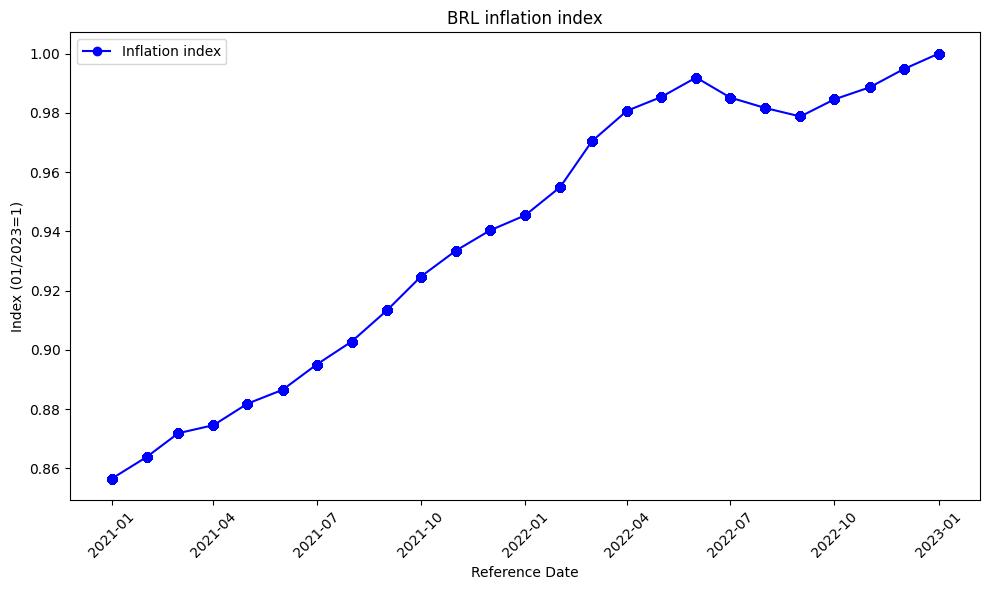

In [12]:
plt.figure(figsize=(10, 6))

# average car price series
plt.plot(df['reference_date'], df['ipca_index'], label='Inflation index', color='blue', marker='o')

# Add labels and title
plt.xlabel('Reference Date')
plt.ylabel('Index (01/2023=1)')
plt.title('BRL inflation index')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Análise interna dos dados

A partir da tabela FIPE, é possível fazer uma análise interna dos fatores que afetam os preços dos carros, ou seja, características que diferem os próprios veículos entre si e afetam seu preço de mercado.

Esta é uma das análises feitas com os dados da tabela, em seguida sendo feita uma análise em cima destes dados e dados de mercados externos.

In [13]:
"""



FAZER PARTE DA ANÁLISE INTERNA AQUI

- USAR O DATAFRAME df_fipe ABAIXO
- JÁ ESTÁ CORRIGIDO PARA INFLAÇÃO
BASE: https://www.kaggle.com/code/ravivarmaodugu/carprices-brazil-eda-ml


"""

df_fipe = df.copy()
df_fipe['avg_price_brl'] = df_fipe['avg_price_brl']/df_fipe['ipca_index']
# drop irrelevant features for the analysis
df_fipe.drop(['ipca_index'], axis=1, inplace=True)
df_fipe.head()

,brand,model,fuel,gear,engine_size,year_model,avg_price_brl,reference_date,age_model
0,Acura,NSX 3.0,Gasoline,manual,3.0000,1995,47137.9699,2021-01-01,26
1,Acura,NSX 3.0,Gasoline,manual,3.0000,1994,45462.5603,2021-01-01,27
2,Acura,NSX 3.0,Gasoline,manual,3.0000,1993,43955.2754,2021-01-01,28
3,Acura,NSX 3.0,Gasoline,manual,3.0000,1992,41986.8151,2021-01-01,29
4,Acura,NSX 3.0,Gasoline,manual,3.0000,1991,38368.6309,2021-01-01,30


In [14]:
df_fipe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 539109 entries, 0 to 599003
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   brand           539109 non-null  object        
 1   model           539109 non-null  object        
 2   fuel            539109 non-null  object        
 3   gear            539109 non-null  object        
 4   engine_size     539109 non-null  float64       
 5   year_model      539109 non-null  int64         
 6   avg_price_brl   539109 non-null  float64       
 7   reference_date  539109 non-null  datetime64[ns]
 8   age_model       539109 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 41.1+ MB


In [15]:
df_fipe.describe().T

,count,mean,min,25%,50%,75%,max,std
engine_size,539109.0000,2.2151,1.0000,1.6000,2.0000,2.6000,6.7000,0.9763
year_model,539109.0000,2009.0730,1985.0000,2002.0000,2010.0000,2016.0000,2023.0000,8.5530
avg_price_brl,539109.0000,75695.4778,7739.0000,23471.0000,45751.7537,93673.4928,478320.6812,80361.3990
reference_date,539109,2022-01-04 04:49:33.305954816,2021-01-01 00:00:00,2021-07-01 00:00:00,2022-01-01 00:00:00,2022-07-01 00:00:00,2023-01-01 00:00:00,NaN
age_model,539109.0000,12.4958,-1.0000,6.0000,11.0000,19.0000,38.0000,8.5754


## Univariate Analysis

### Distribution of average prices

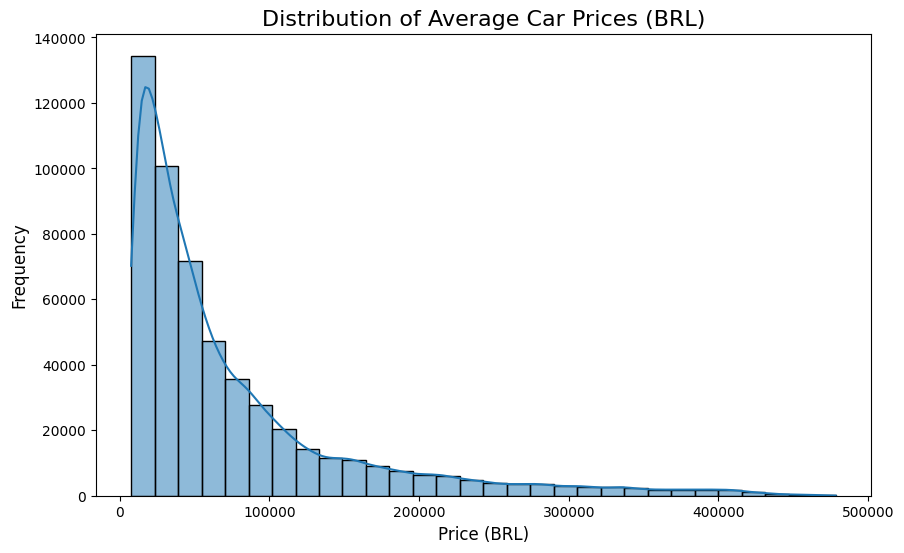

In [16]:
# Plot a histogram of the average price
plt.figure(figsize=(10,6))
sns.histplot(df_fipe['avg_price_brl'], bins=30, kde=True)
plt.title('Distribution of Average Car Prices (BRL)', fontsize=16)
plt.xlabel('Price (BRL)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


- This histogram shows the distribution of car prices in Brazilian real (BRL).
- The data is highly skewed to the right, with most car prices concentrated between 0 and 100,000 BRL.
- There are very few cars priced above 150,000 BRL, suggesting that high-end vehicles represent a small portion of the market.

### Fuel type distribution

/tmp/ipykernel_1899/1594486937.py:16: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  ax.legend(wedges, fuel_counts.index,


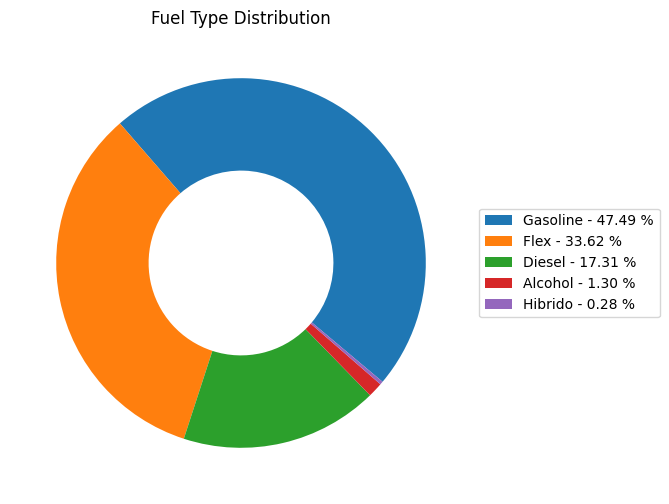

In [70]:
# Pie chart for fuel type distribution
fuel_counts = df_fipe['fuel'].value_counts()


fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(fuel_counts, wedgeprops=dict(width=0.5), startangle=-40)


bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

#labels = [f'{l}, {s:0.1f}%' for l, s in zip(fuel_counts.index, fuel_counts)]
porcent = 100.*fuel_counts/fuel_counts.sum()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(fuel_counts.index, porcent)]

ax.legend(wedges, fuel_counts.index,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), labels=labels),


#plt.figure(figsize=(8,8))
#plt.pie(fuel_counts, labels=fuel_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
#plt.title('Fuel Type Distribution', fontsize=16)
ax.set_title("Fuel Type Distribution")

plt.show()


- This pie chart illustrates the distribution of different fuel types used by cars.
- A large majority of cars (81.3%) run on gasoline, followed by diesel-powered cars (17.3%).
- Alcohol (1.4%) represents a very small fraction of fuel types, indicating that alternative fuels are not yet widely adopted.

### Gear type distribution

/tmp/ipykernel_1899/234953481.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gear', data=df_fipe, palette='Set3')


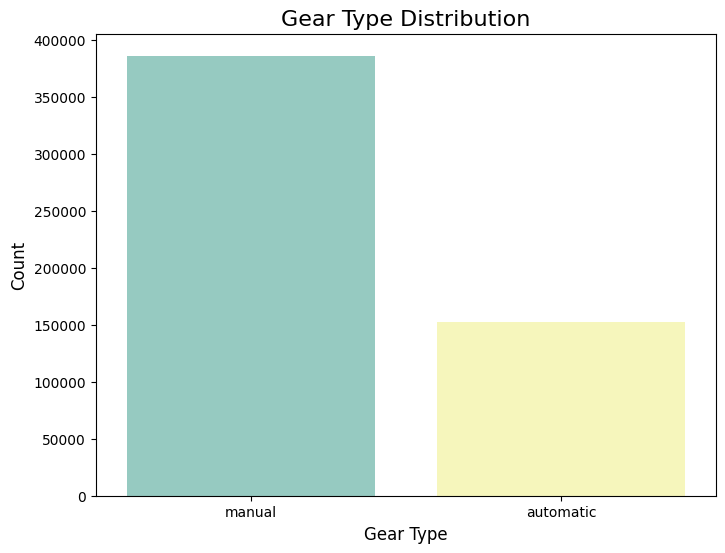

In [18]:
# Bar plot for gear type distribution
plt.figure(figsize=(8,6))
sns.countplot(x='gear', data=df_fipe, palette='Set3')
plt.title('Gear Type Distribution', fontsize=16)
plt.xlabel('Gear Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


- The bar chart shows the distribution of manual and automatic transmission types.
- Manual transmission dominates the market, with nearly 400,000 cars, while automatic cars are significantly fewer in number, under 150,000.
- This highlights a strong preference for manual vehicles in this dataset.

### Brand analysis

/tmp/ipykernel_1899/3825091217.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.index, y=top_brands.values, palette='viridis')


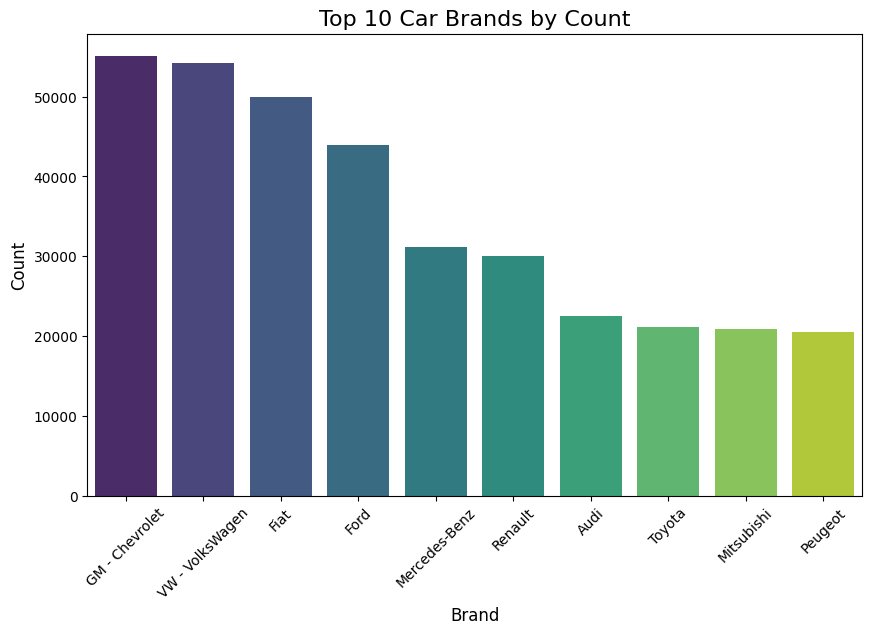

In [19]:
# Bar plot for brand distribution (Top 10 brands by count)
plt.figure(figsize=(10,6))
top_brands = df_fipe['brand'].value_counts().head(10)

sns.barplot(x=top_brands.index, y=top_brands.values, palette='viridis')
plt.title('Top 10 Car Brands by Count', fontsize=16)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()


- This bar chart ranks the top 10 car brands based on their frequency in the dataset.
- Chevrolet and Volkswagen lead the market, with Chevrolet slightly ahead, followed closely by Fiat and Ford.
- Other notable brands include Mercedes-Benz, Renault, and Toyota, while brands like Mitsubishi and Peugeot have fewer cars in the dataset.

## Bivariate Analysis

### Fuel type vs Average Price

/tmp/ipykernel_1899/2650970219.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fuel', y='avg_price_brl', data=df_fipe, palette='Set1')


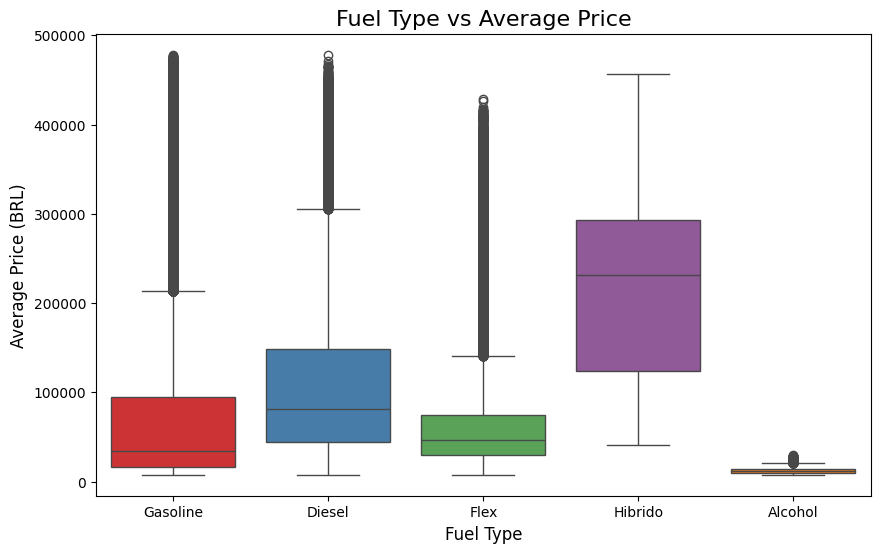

In [20]:
# Box plot for fuel type vs average price
plt.figure(figsize=(10,6))
sns.boxplot(x='fuel', y='avg_price_brl', data=df_fipe, palette='Set1')
plt.title('Fuel Type vs Average Price', fontsize=16)
plt.xlabel('Fuel Type', fontsize=12)
plt.ylabel('Average Price (BRL)', fontsize=12)
plt.show()


- This boxplot compares the average car price for different fuel types (Gasoline, Diesel, Alcohol).
- Diesel cars generally have a higher price range, with a larger interquartile range, while gasoline cars show lower prices and alcohol-powered cars have the lowest prices.
- This suggests that fuel type significantly impacts car pricing, with diesel vehicles being more expensive on average.

### Gear type vs Average Price

/tmp/ipykernel_1899/2345045270.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gear', y='avg_price_brl', data=df_fipe, palette='Set2')


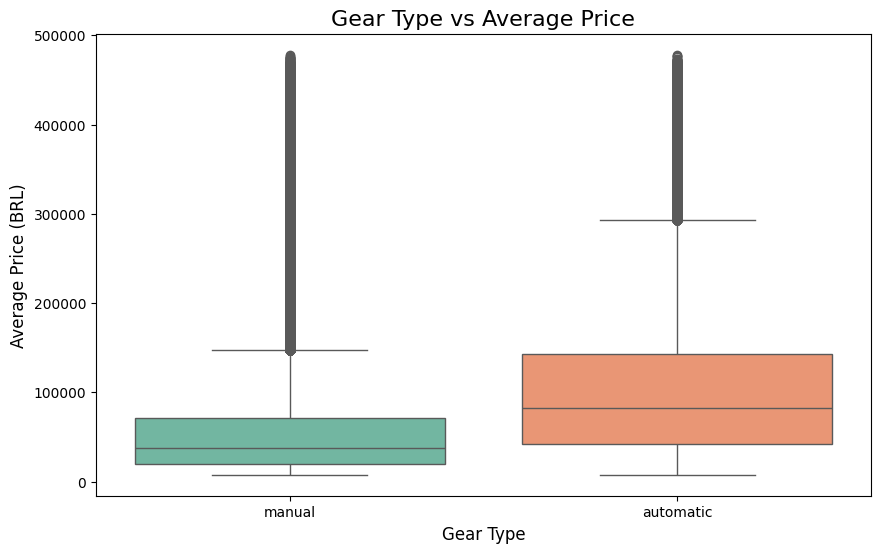

In [21]:
# Box plot for gear type vs average price
plt.figure(figsize=(10,6))
sns.boxplot(x='gear', y='avg_price_brl', data=df_fipe, palette='Set2')
plt.title('Gear Type vs Average Price', fontsize=16)
plt.xlabel('Gear Type', fontsize=12)
plt.ylabel('Average Price (BRL)', fontsize=12)
plt.show()


- This graph compares the price distribution between manual and automatic cars.
- Cars with automatic transmission tend to be more expensive than manual ones, as indicated by the higher median and wider price distribution.
- This indicates that gear type is also a key factor affecting car prices.

### Brand vs Average Price

/tmp/ipykernel_1899/351257880.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_by_brand.index, y=avg_price_by_brand.values, palette='magma')


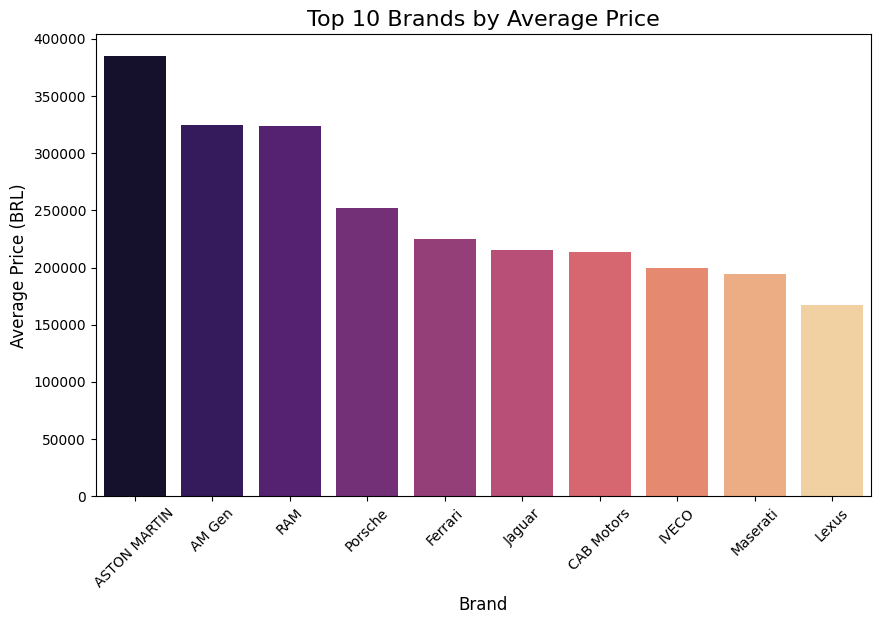

In [22]:
# Bar plot for average price by brand (Top 10 brands by average price)
plt.figure(figsize=(10,6))
avg_price_by_brand = df_fipe.groupby('brand')['avg_price_brl'].mean().sort_values(ascending=False).head(10)

sns.barplot(x=avg_price_by_brand.index, y=avg_price_by_brand.values, palette='magma')
plt.title('Top 10 Brands by Average Price', fontsize=16)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Average Price (BRL)', fontsize=12)
plt.xticks(rotation=45)
plt.show()


- This bar chart shows the average price for the top 10 car brands.
- Audi leads with the highest average price, followed by Mercedes-Benz and Ford. This suggests that premium brands tend to have higher pricing.
- It highlights how brand reputation and market positioning influence car prices.

## Multivariate Analysis

### Fuel Type, Gear Type, and Price

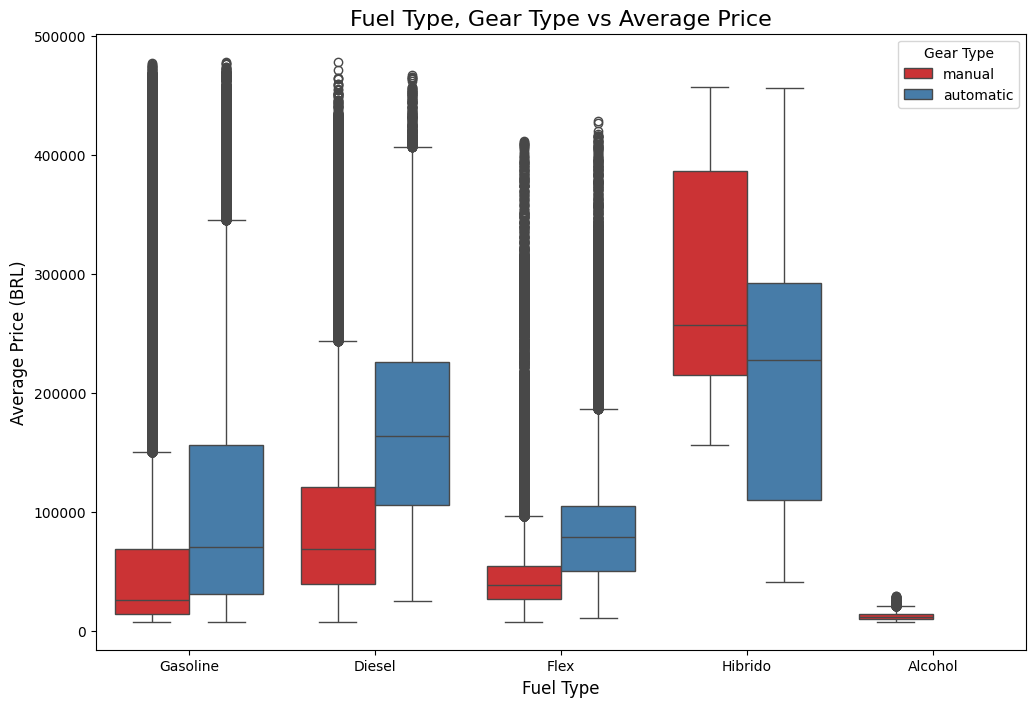

In [23]:
# Box plot for fuel type and gear type vs average price
plt.figure(figsize=(12,8))
sns.boxplot(x='fuel', y='avg_price_brl', hue='gear', data=df_fipe, palette='Set1')
plt.title('Fuel Type, Gear Type vs Average Price', fontsize=16)
plt.xlabel('Fuel Type', fontsize=12)
plt.ylabel('Average Price (BRL)', fontsize=12)
plt.legend(title='Gear Type')
plt.show()


- For each fuel type, there's a comparison between manual (red) and automatic (blue) transmission vehicles.
- Across all fuel types, automatic transmission vehicles tend to be more expensive than their manual counterparts.

## Time-Based Analysis

### Year of the model vs Average Price

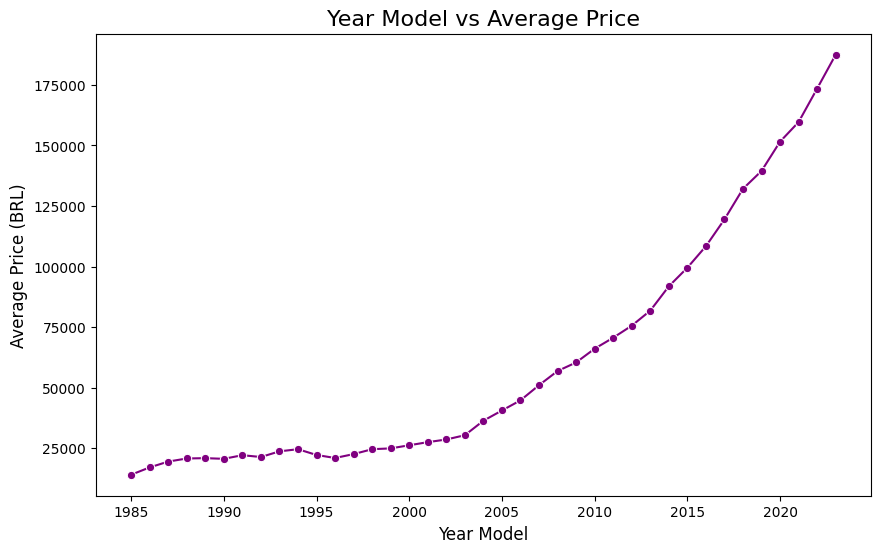

In [24]:
# Line plot for year model vs average price
plt.figure(figsize=(10,6))
df_fipe_sorted = df_fipe.groupby('year_model')['avg_price_brl'].mean().reset_index()

sns.lineplot(x='year_model', y='avg_price_brl', data=df_fipe_sorted, marker='o', color='purple')
plt.title('Year Model vs Average Price', fontsize=16)
plt.xlabel('Year Model', fontsize=12)
plt.ylabel('Average Price (BRL)', fontsize=12)
plt.show()


- This line graph illustrates the trend of car prices over different model years.
- The upward slope shows that newer models tend to be more expensive, especially from around 2010 onward, with a sharp increase after 2020.
- This graph provides insight into how car prices have risen over time, possibly due to inflation, technological advancements, and regulatory changes.

## Conclusion internal factors : 
- Fuel Type:
    - Diesel-powered cars tend to be more expensive compared to gasoline and alcohol-powered vehicles. This is likely due to their efficiency, durability, and suitability for heavy-duty usage.
    - Gasoline cars are the most common, but they generally have lower prices than diesel cars, reflecting their broader availability and consumer demand for less expensive fuel types.
    - Alcohol (ethanol) cars are the least expensive, likely due to their lower demand and perhaps lower production costs or market niche.

- Gear Type :
    - Automatic transmission cars are significantly more expensive than manual transmission cars.
    - The difference in price suggests that manufacturers charge a premium for automatic transmission due to higher production costs and the value perceived by buyers.

- Engine Size and Car Brand : 
    - Larger engine sizes generally correlate with higher prices, as larger engines typically offer more power, better performance, and higher production costs.
    - However, the brand plays a major role in the final price, as some premium brands charge more even for smaller engines, indicating that engine size alone isn't the sole driver of price—it's the combination of engine size and brand reputation that matters.

-  Model Year : 
    - Newer models are consistently more expensive, as shown by the clear upward trend in prices over time. This could be attributed to advancements in technology, safety features, regulatory requirements, and inflation. Exponentional tendancy.

## Extraindo séries dos dados

Agora que temos um dataframe tratado com dados da tabela FIPE, podemos retirar algumas séries temporais destes dados.

Isso será útil para relacionar estes dados com valores externos às características dos carros, como séries de preços de commodities.

In [25]:
df['fuel'].value_counts()

fuel
Gasoline    255999
Flex        181249
Diesel       93338
Alcohol       6995
Hibrido       1528
Name: count, dtype: int64

In [26]:
df['gear'].value_counts()

gear
manual       386500
automatic    152609
Name: count, dtype: int64

In [27]:
df['age_model'].value_counts()

age_model
 7     24299
 9     23999
 8     23854
 6     23419
 10    23367
 11    21938
 5     21702
 4     20767
 12    20751
 3     19816
 13    19024
-1     18729
 2     18569
 14    17694
 15    17004
 1     16701
 21    16447
 16    16259
 0     16234
 22    15911
 20    15649
 17    14876
 23    14760
 19    14531
 18    14252
 24    12409
 25    10328
 26    10304
 27     9681
 28     7468
 29     5727
 30     4129
 31     2507
 32     1560
 33     1287
 34     1080
 35      958
 36      751
 37      342
 38       26
Name: count, dtype: int64

In [28]:
# corrigindo valores
df_timeseries = df.copy()
df_timeseries['avg_price_inflation'] = df_timeseries['avg_price_brl']
df_timeseries['avg_price_brl'] = df_timeseries['avg_price_brl']/df_timeseries['ipca_index'] 
df_timeseries.drop(['ipca_index'], axis=1, inplace=True)
df_timeseries.head()

,brand,model,fuel,gear,engine_size,year_model,avg_price_brl,reference_date,age_model,avg_price_inflation
0,Acura,NSX 3.0,Gasoline,manual,3.0000,1995,47137.9699,2021-01-01,26,40374.0000
1,Acura,NSX 3.0,Gasoline,manual,3.0000,1994,45462.5603,2021-01-01,27,38939.0000
2,Acura,NSX 3.0,Gasoline,manual,3.0000,1993,43955.2754,2021-01-01,28,37648.0000
3,Acura,NSX 3.0,Gasoline,manual,3.0000,1992,41986.8151,2021-01-01,29,35962.0000
4,Acura,NSX 3.0,Gasoline,manual,3.0000,1991,38368.6309,2021-01-01,30,32863.0000


In [29]:
# agrupando dados por reference_date
df_timeseries = df_timeseries.groupby('reference_date').agg(
    # preço médio geral dos carros
    inflated_car_prices=('avg_price_inflation', 'mean'),
    
    # preço médio geral dos carros
    car_prices=('avg_price_brl', 'mean'),

    # preço médio dos carros a gasolina
    car_prices_gasoline=('avg_price_brl', lambda x: x[df_timeseries['fuel'] == 'Gasoline'].mean()),

    # preço médio dos carros a diesel
    car_prices_diesel=('avg_price_brl', lambda x: x[df_timeseries['fuel'] == 'Diesel'].mean()),

    # preço médio dos carros a álcool
    car_prices_alcohol=('avg_price_brl', lambda x: x[df_timeseries['fuel'] == 'Alcohol'].mean()),

    # preço médio dos carros automáticos
    car_prices_automatic=('avg_price_brl', lambda x: x[df_timeseries['gear'] == 'automatic'].mean()),

    # preço médio dos carros manuais
    car_prices_manual=('avg_price_brl', lambda x: x[df_timeseries['gear'] == 'manual'].mean()),

    # preço médio dos carros 'novos' (ano de lançamento e 2 anteriores)
    car_prices_new=('avg_price_brl', lambda x: x[df_timeseries['year_model'] >= 2021].mean()),

    # preço médio dos carros 'antigos' (10 anos ou mais)
    car_prices_old=('avg_price_brl', lambda x: x[df['year_model'] <= 2010].mean())
).reset_index()

# ordenando por reference_date
df_timeseries = df_timeseries.sort_values(by='reference_date')

df_timeseries.head()

,reference_date,inflated_car_prices,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old
0,2021-01-01,62786.0014,73304.7169,80893.6865,93337.8206,12647.9031,104123.7912,61218.8861,158007.9151,36434.2778
1,2021-02-01,63152.0591,73103.4200,80568.5383,93052.1475,12533.5856,104018.5173,60962.1057,159278.6159,36184.8238
2,2021-03-01,63662.5712,73015.3168,79875.1521,93423.8779,12414.6058,103997.4753,60769.6331,159322.4579,36026.1699
3,2021-04-01,64813.6637,74105.8109,79974.7719,96280.4699,12317.7649,105636.6347,61632.0784,162107.6181,36360.3005
4,2021-05-01,65453.4192,74221.2005,79665.4718,97190.0710,12213.4363,105640.0441,61757.6133,162846.0073,36321.2335


### Visualização das séries extraídas

Agora, podemos plotar algumas dessas séries e observar suas características.

In [30]:
# dataframe normalizado para que o 'desenho' das séries seja melhor comparado em gráficos com múltiplas séries
# cada série se torna um crescimento percentual relativo ao dado inicial

df_normalized_ts = df_timeseries.copy()
for col in df_normalized_ts.columns:
    if col == "reference_date":
        continue
    df_first = df_normalized_ts[col][0]
    df_normalized_ts[col] = (df_normalized_ts[col] - df_first)/(df_first)

df_normalized_ts.head()

,reference_date,inflated_car_prices,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old
0,2021-01-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2021-02-01,0.0058,-0.0027,-0.0040,-0.0031,-0.0090,-0.0010,-0.0042,0.0080,-0.0068
2,2021-03-01,0.0140,-0.0039,-0.0126,0.0009,-0.0184,-0.0012,-0.0073,0.0083,-0.0112
3,2021-04-01,0.0323,0.0109,-0.0114,0.0315,-0.0261,0.0145,0.0067,0.0259,-0.0020
4,2021-05-01,0.0425,0.0125,-0.0152,0.0413,-0.0344,0.0146,0.0088,0.0306,-0.0031


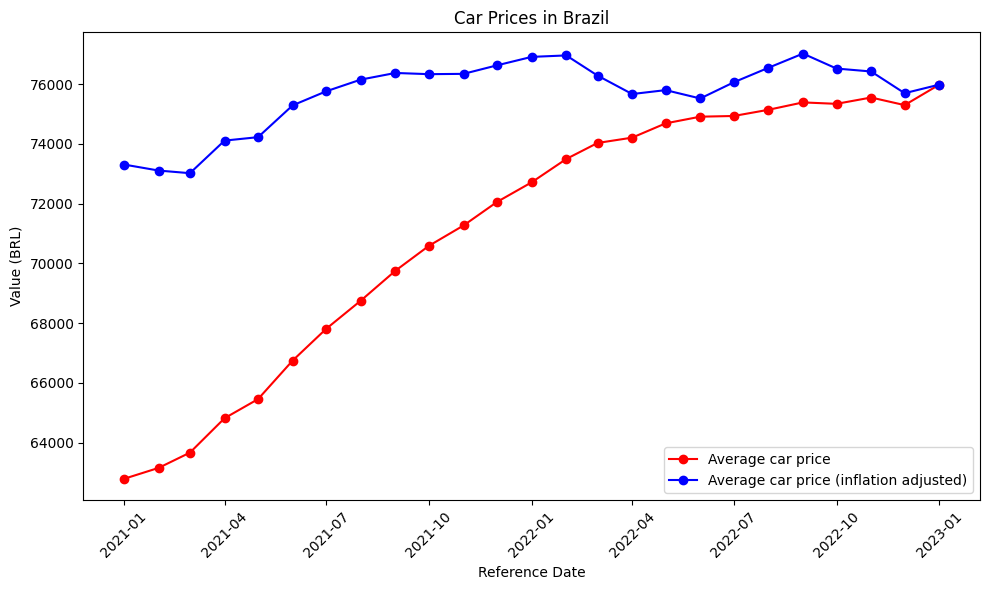

In [31]:
plt.figure(figsize=(10, 6))

# average car price series
plt.plot(df_timeseries['reference_date'], df_timeseries['inflated_car_prices'], label='Average car price', color='red', marker='o')
plt.plot(df_timeseries['reference_date'], df_timeseries['car_prices'], label='Average car price (inflation adjusted)', color='blue', marker='o')

# Add labels and title
plt.xlabel('Reference Date')
plt.ylabel('Value (BRL)')
plt.title('Car Prices in Brazil')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Neste primeiro gráfico já é possível perceber que o preço médio dos carros cresceu consideravelmente, mesmo se ajustado para inflação do período.

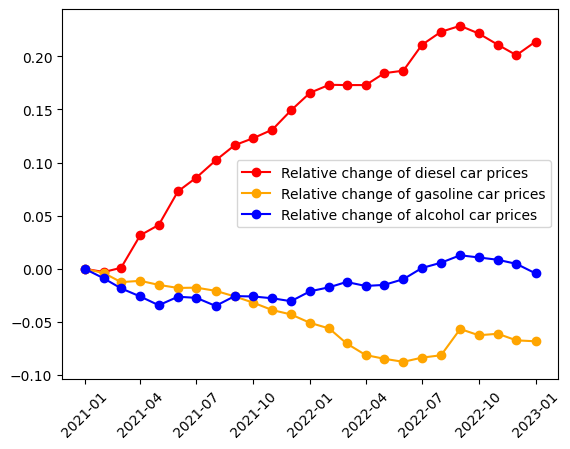

In [32]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_diesel'], label='Relative change of diesel car prices', color='red', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_gasoline'], label='Relative change of gasoline car prices', color='orange', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_alcohol'], label='Relative change of alcohol car prices', color='blue', marker='o')


# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()

O preço dos carros a diesel observou um crescimento consideravelmente maior que os outros carros, um aumento de mais de 60% no período sem a inflação.

Os carros a álcool e gasolina observaram um aumento parecido, em torno de 35% no período.

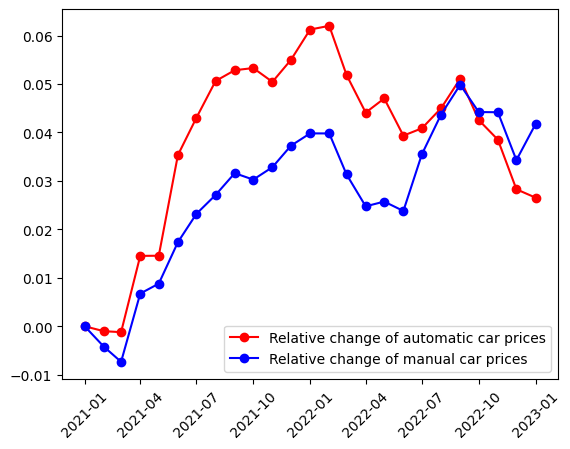

In [33]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_automatic'], label='Relative change of automatic car prices', color='red', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_manual'], label='Relative change of manual car prices', color='blue', marker='o')

# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()

O crescimento relativo de preço de carros automáticos e manuais foi praticamente igual.

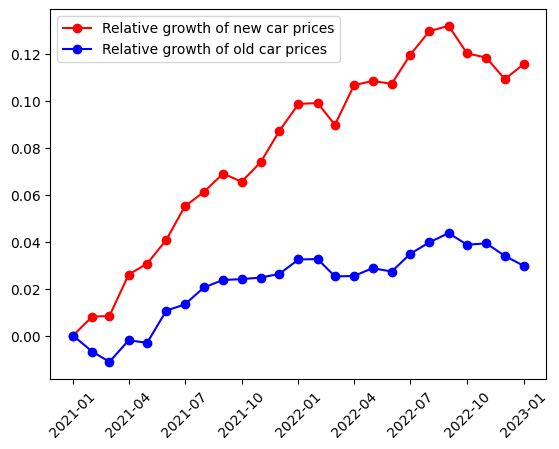

In [34]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_new'], label='Relative growth of new car prices', color='red', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_old'], label='Relative growth of old car prices', color='blue', marker='o')

# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()

O crescimento relativo de preço de carros novos (ano de lançamento + anterior) foi maior do que o de carros antigos, apesar do crescimento de ambos.

## Incluindo outros dados

Agora, outras séries temporais são incluídas para fim de comparação com as séries de preços de carro.

In [35]:
# série combustíveis
combustiveis = pd.read_csv('data/combustiveis-brasil.csv', delimiter=';')
combustiveis.head()

,data,etanol hidratado,gasolina comum,óleo diesel
0,01/01/2021,3.2210,4.6220,3.6960
1,01/02/2021,3.4290,4.9510,3.9510
2,01/03/2021,4.0380,5.4840,4.2520
3,01/04/2021,3.8260,5.4480,4.2020
4,01/05/2021,4.2500,5.6040,4.4700


In [36]:
# renomeando colunas
combustiveis.columns = ['reference_date', 'alcohol_price', 'gasoline_price', 'diesel_price']

# adicionando coluna reference_date
combustiveis['reference_date'] = pd.to_datetime(combustiveis['reference_date'], format='%d/%m/%Y')

# ajustando inflação
combustiveis = pd.merge(combustiveis, inflacao, how='left', on='reference_date')
combustiveis['alcohol_price'] = combustiveis['alcohol_price']/combustiveis['ipca_index']
combustiveis['gasoline_price'] = combustiveis['gasoline_price']/combustiveis['ipca_index'] 
combustiveis['diesel_price'] = combustiveis['diesel_price']/combustiveis['ipca_index']
combustiveis.drop(['ipca_index'], axis=1, inplace=True)

df_timeseries = pd.merge(df_timeseries, combustiveis, how='inner', on='reference_date')
df_timeseries.head()

,reference_date,inflated_car_prices,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old,alcohol_price,gasoline_price,diesel_price
0,2021-01-01,62786.0014,73304.7169,80893.6865,93337.8206,12647.9031,104123.7912,61218.8861,158007.9151,36434.2778,3.7606,5.3963,4.3152
1,2021-02-01,63152.0591,73103.4200,80568.5383,93052.1475,12533.5856,104018.5173,60962.1057,159278.6159,36184.8238,3.9693,5.7312,4.5736
2,2021-03-01,63662.5712,73015.3168,79875.1521,93423.8779,12414.6058,103997.4753,60769.6331,159322.4579,36026.1699,4.6312,6.2897,4.8767
3,2021-04-01,64813.6637,74105.8109,79974.7719,96280.4699,12317.7649,105636.6347,61632.0784,162107.6181,36360.3005,4.3745,6.2291,4.8044
4,2021-05-01,65453.4192,74221.2005,79665.4718,97190.0710,12213.4363,105640.0441,61757.6133,162846.0073,36321.2335,4.8193,6.3547,5.0688


In [37]:
# série preço de aço
aco = pd.read_csv('data/preco_aco.csv', delimiter=';')
aco.head()

,Data,Preço aço
0,01.01.2023,788.0000
1,01.12.2022,744.0000
2,01.11.2022,655.0000
3,01.10.2022,713.0000
4,01.09.2022,776.0000


In [38]:
# renomeando colunas
aco.columns = ['reference_date', 'steel_price']

# adicionando coluna reference_date
aco['reference_date'] = pd.to_datetime(aco['reference_date'], format='%d.%m.%Y')

# ajustando dólar/inflação
aco = pd.merge(aco, dolar, how='left', on='reference_date')
aco = pd.merge(aco, inflacao, how='left', on='reference_date')

aco['steel_price'] = aco['steel_price']*aco['dollar_price']
aco.drop(['ipca_index', 'dollar_price'], axis=1, inplace=True)

df_timeseries = pd.merge(df_timeseries, aco, how='inner', on='reference_date')
df_timeseries.head()

,reference_date,inflated_car_prices,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old,alcohol_price,gasoline_price,diesel_price,steel_price
0,2021-01-01,62786.0014,73304.7169,80893.6865,93337.8206,12647.9031,104123.7912,61218.8861,158007.9151,36434.2778,3.7606,5.3963,4.3152,6276.4125
1,2021-02-01,63152.0591,73103.4200,80568.5383,93052.1475,12533.5856,104018.5173,60962.1057,159278.6159,36184.8238,3.9693,5.7312,4.5736,7076.6304
2,2021-03-01,63662.5712,73015.3168,79875.1521,93423.8779,12414.6058,103997.4753,60769.6331,159322.4579,36026.1699,4.6312,6.2897,4.8767,7591.2620
3,2021-04-01,64813.6637,74105.8109,79974.7719,96280.4699,12317.7649,105636.6347,61632.0784,162107.6181,36360.3005,4.3745,6.2291,4.8044,8182.0830
4,2021-05-01,65453.4192,74221.2005,79665.4718,97190.0710,12213.4363,105640.0441,61757.6133,162846.0073,36321.2335,4.8193,6.3547,5.0688,8686.6380


In [39]:
# série venda de carros
car_sales = pd.read_csv('data/venda_carros.csv', delimiter=';')
car_sales.head()

,data,venda carros
0,01/02/1981,65251
1,01/03/1981,64065
2,01/04/1981,69042
3,01/05/1981,62966
4,01/06/1981,61271


In [40]:
# renomeando colunas
car_sales.columns = ['reference_date', 'car_sales']

# adicionando coluna reference_date
car_sales['reference_date'] = pd.to_datetime(car_sales['reference_date'], format='%d/%m/%Y')

df_timeseries = pd.merge(df_timeseries, car_sales, how='inner', on='reference_date')
df_timeseries.head()

,reference_date,inflated_car_prices,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old,alcohol_price,gasoline_price,diesel_price,steel_price,car_sales
0,2021-01-01,62786.0014,73304.7169,80893.6865,93337.8206,12647.9031,104123.7912,61218.8861,158007.9151,36434.2778,3.7606,5.3963,4.3152,6276.4125,180904
1,2021-02-01,63152.0591,73103.4200,80568.5383,93052.1475,12533.5856,104018.5173,60962.1057,159278.6159,36184.8238,3.9693,5.7312,4.5736,7076.6304,186718
2,2021-03-01,63662.5712,73015.3168,79875.1521,93423.8779,12414.6058,103997.4753,60769.6331,159322.4579,36026.1699,4.6312,6.2897,4.8767,7591.2620,208801
3,2021-04-01,64813.6637,74105.8109,79974.7719,96280.4699,12317.7649,105636.6347,61632.0784,162107.6181,36360.3005,4.3745,6.2291,4.8044,8182.0830,191853
4,2021-05-01,65453.4192,74221.2005,79665.4718,97190.0710,12213.4363,105640.0441,61757.6133,162846.0073,36321.2335,4.8193,6.3547,5.0688,8686.6380,206221


In [41]:
# série índice de semicondutores
semiconductor_index = pd.read_csv('data/semiconductor-index.csv', delimiter=',')
semiconductor_index.head()

,DATE,PCU33443344
0,2021-01-01,54.1000
1,2021-02-01,54.1000
2,2021-03-01,54.3000
3,2021-04-01,54.2000
4,2021-05-01,54.5000


In [42]:
# renomeando colunas
semiconductor_index.columns = ['reference_date', 'semiconductor_index']

# adicionando coluna reference_date
semiconductor_index['reference_date'] = pd.to_datetime(semiconductor_index['reference_date'], format='%Y-%m-%d')

# usando 2021-01 como índice (100)
semiconductor_index['semiconductor_index'] = 100*semiconductor_index['semiconductor_index']/semiconductor_index['semiconductor_index'][0]

df_timeseries = pd.merge(df_timeseries, semiconductor_index, how='inner', on='reference_date')
df_timeseries.head()

,reference_date,inflated_car_prices,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old,alcohol_price,gasoline_price,diesel_price,steel_price,car_sales,semiconductor_index
0,2021-01-01,62786.0014,73304.7169,80893.6865,93337.8206,12647.9031,104123.7912,61218.8861,158007.9151,36434.2778,3.7606,5.3963,4.3152,6276.4125,180904,100.0000
1,2021-02-01,63152.0591,73103.4200,80568.5383,93052.1475,12533.5856,104018.5173,60962.1057,159278.6159,36184.8238,3.9693,5.7312,4.5736,7076.6304,186718,100.0000
2,2021-03-01,63662.5712,73015.3168,79875.1521,93423.8779,12414.6058,103997.4753,60769.6331,159322.4579,36026.1699,4.6312,6.2897,4.8767,7591.2620,208801,100.3697
3,2021-04-01,64813.6637,74105.8109,79974.7719,96280.4699,12317.7649,105636.6347,61632.0784,162107.6181,36360.3005,4.3745,6.2291,4.8044,8182.0830,191853,100.1848
4,2021-05-01,65453.4192,74221.2005,79665.4718,97190.0710,12213.4363,105640.0441,61757.6133,162846.0073,36321.2335,4.8193,6.3547,5.0688,8686.6380,206221,100.7394


## Observando novos dados em relação aos preços de automóveis

Agora, podemos observar relações entre os dados importados e os preços de automóveis.

In [43]:
# dataset de mudanças percentuais em relação ao valor inicial
df_percentual_ts = df_timeseries.copy()
for col in df_percentual_ts.columns:
    if col == "reference_date":
        continue
    df_first = df_percentual_ts[col][0]
    df_percentual_ts[col] = (df_percentual_ts[col] - df_first)/(df_first)

df_percentual_ts.head()

,reference_date,inflated_car_prices,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old,alcohol_price,gasoline_price,diesel_price,steel_price,car_sales,semiconductor_index
0,2021-01-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2021-02-01,0.0058,-0.0027,-0.0040,-0.0031,-0.0090,-0.0010,-0.0042,0.0080,-0.0068,0.0555,0.0620,0.0599,0.1275,0.0321,0.0000
2,2021-03-01,0.0140,-0.0039,-0.0126,0.0009,-0.0184,-0.0012,-0.0073,0.0083,-0.0112,0.2315,0.1655,0.1301,0.2095,0.1542,0.0037
3,2021-04-01,0.0323,0.0109,-0.0114,0.0315,-0.0261,0.0145,0.0067,0.0259,-0.0020,0.1632,0.1543,0.1134,0.3036,0.0605,0.0018
4,2021-05-01,0.0425,0.0125,-0.0152,0.0413,-0.0344,0.0146,0.0088,0.0306,-0.0031,0.2815,0.1776,0.1746,0.3840,0.1399,0.0074


In [44]:
# dataset normalizado em relação aos valores máx/mín
df_normalized_ts = df_timeseries.copy()
for col in df_normalized_ts.columns:
    if col == "reference_date":
        continue
    df_max = max(df_normalized_ts[col])
    df_min = min(df_normalized_ts[col])
    df_change = df_max - df_min
    df_normalized_ts[col] = 2*(df_normalized_ts[col] - df_min)/(df_change) - 1

df_normalized_ts.head()

,reference_date,inflated_car_prices,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old,alcohol_price,gasoline_price,diesel_price,steel_price,car_sales,semiconductor_index
0,2021-01-01,-1.0000,-0.8554,1.0000,-0.9736,0.4673,-0.9616,-0.7434,-1.0000,-0.5913,-0.8132,-0.6452,-1.0000,-0.1706,-0.0588,-1.0000
1,2021-02-01,-0.9445,-0.9560,0.9083,-1.0000,0.0884,-0.9936,-0.8901,-0.8780,-0.8411,-0.6232,-0.3686,-0.8413,0.0599,0.0633,-1.0000
2,2021-03-01,-0.8671,-1.0000,0.7127,-0.9656,-0.3061,-1.0000,-1.0000,-0.8738,-1.0000,-0.0207,0.0926,-0.6552,0.2081,0.5272,-0.8859
3,2021-04-01,-0.6926,-0.4552,0.7408,-0.7016,-0.6271,-0.5020,-0.5073,-0.6064,-0.6654,-0.2544,0.0425,-0.6996,0.3782,0.1712,-0.9430
4,2021-05-01,-0.5956,-0.3975,0.6535,-0.6175,-0.9730,-0.5010,-0.4356,-0.5355,-0.7045,0.1505,0.1463,-0.5373,0.5235,0.4730,-0.7719


### Preços de carros de diferentes combustíveis e preço dos combustíveis

Abaixo, podemos ver as relações entre as variações nos preços de combustíveis e seus respectivos veículos.
Nota-se que a relação é particularmente alta em relação aos carros que utilizam óleo diesel, combustível cujo preço mais cresceu.

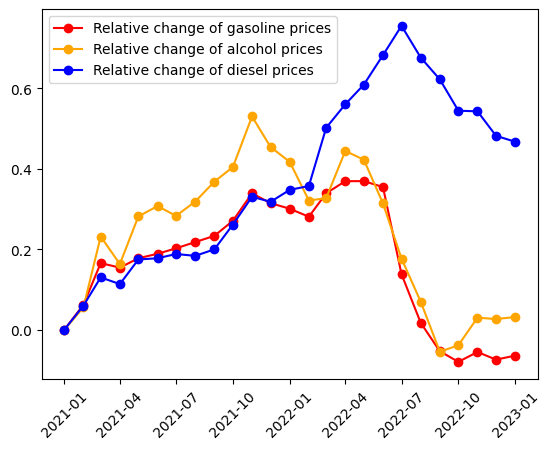

In [45]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_percentual_ts['reference_date'], df_percentual_ts['gasoline_price'], label='Relative change of gasoline prices', color='red', marker='o')
plt.plot(df_percentual_ts['reference_date'], df_percentual_ts['alcohol_price'], label='Relative change of alcohol prices', color='orange', marker='o')
plt.plot(df_percentual_ts['reference_date'], df_percentual_ts['diesel_price'], label='Relative change of diesel prices', color='blue', marker='o')

# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()

In [46]:
# tabela de correlações: preços de carros de combustíveis e gasolinas
columns_fuel = ["car_prices_gasoline", "car_prices_diesel", "car_prices_alcohol", "gasoline_price", "diesel_price", "alcohol_price"]
fuel_correlation = df_timeseries[columns_fuel].corr()

fuel_correlation[:3][["gasoline_price", "diesel_price", "alcohol_price"]]

,gasoline_price,diesel_price,alcohol_price
car_prices_gasoline,-0.0672,-0.9636,-0.0033
car_prices_diesel,-0.1212,0.9096,-0.1050
car_prices_alcohol,-0.7152,0.5863,-0.7946


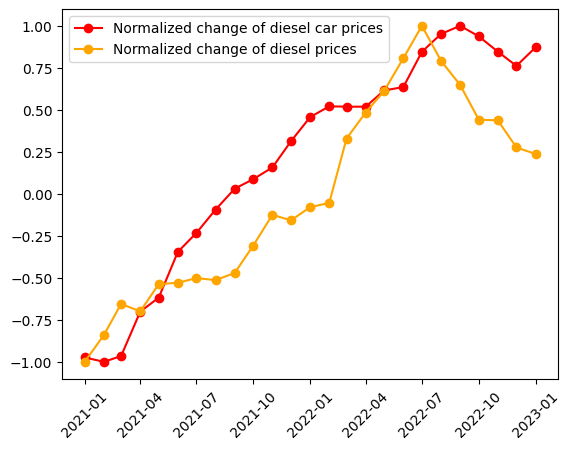

In [47]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_diesel'], label='Normalized change of diesel car prices', color='red', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['diesel_price'], label='Normalized change of diesel prices', color='orange', marker='o')

# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()

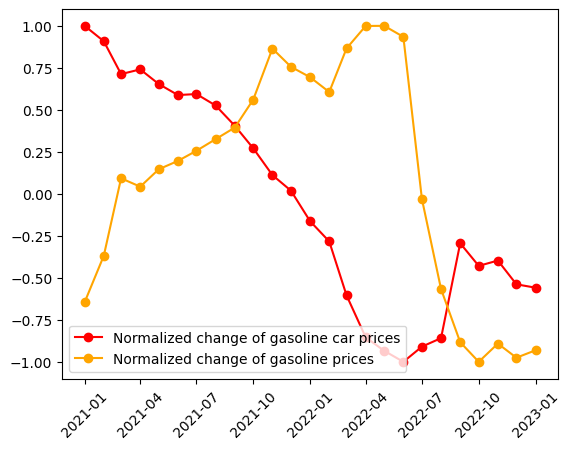

In [48]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_gasoline'], label='Normalized change of gasoline car prices', color='red', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['gasoline_price'], label='Normalized change of gasoline prices', color='orange', marker='o')

# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()

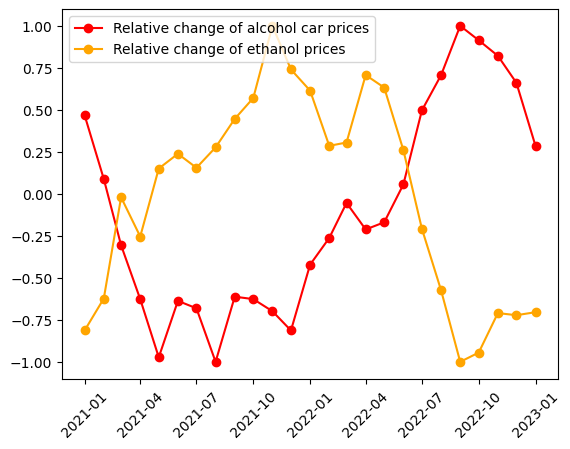

In [49]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_alcohol'], label='Relative change of alcohol car prices', color='red', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['alcohol_price'], label='Relative change of ethanol prices', color='orange', marker='o')

# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()

### Preços dos carros relativo ao mercado do aço e semicondutores

Olhando as variações de preços de diferentes mercados com o mercado automobilístico, nota-se uma correlação muito alta entre o preço dos carros e o mercado de semicondutores. Isso também pode ser verificado visualmente através de suas séries normalizadas.

In [50]:
# tabela de correlações: preços de carros de combustíveis e gasolinas
columns_markets = ["car_prices", "car_sales", "steel_price", "semiconductor_index"]
market_correlation = df_timeseries[columns_markets].corr()

market_correlation[:2][["steel_price", "semiconductor_index", "car_sales"]]

,steel_price,semiconductor_index,car_sales
car_prices,-0.2005,0.6346,-0.1758
car_sales,-0.3539,0.1605,1.0000


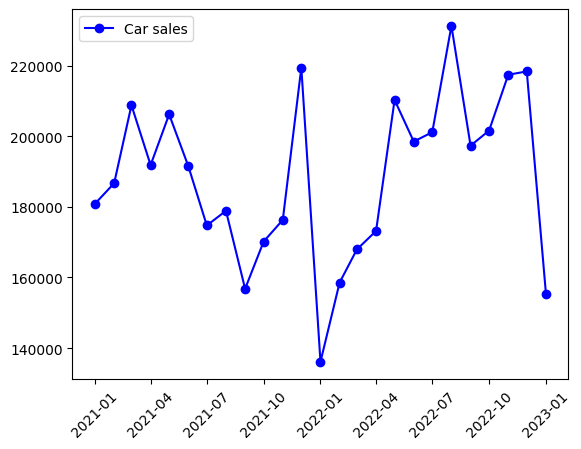

In [51]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
#plt.plot(df_normalized_ts['reference_date'], df_percentual_ts['steel_price'], label='Relative change of steel prices', color='red', marker='o')
plt.plot(df_timeseries['reference_date'], df_timeseries['car_sales'], label='Car sales', color='blue', marker='o')

# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()